In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
#from visualization import visualize, display, sequence_identity
from rdkit.Chem import AllChem
from scipy.stats import spearmanr, ttest_ind

def get_accuracy_level(predicted_ECs, true_ECs):
    """
    based on a list of predicted_ECs, calculates the highest level of accuracy achieved
    """
    #convert true_EC to a list
    if type(predicted_ECs) == str:
        predicted_ECs = [predicted_ECs]
        
    if type(true_ECs) == str:
        true_ECs = [true_ECs]

    maxes = []
    for true_EC in true_ECs:

        true_split = true_EC.split('.')
        
        counters = []
        for predicted_EC in predicted_ECs:
            #print(true_EC)
            predicted_split = predicted_EC.split('.')
            counter = 0
            
            for predicted, true in zip(predicted_split, true_split):
                if predicted == true:
                    counter += 1
                else:
                    break
            counters.append(counter)
            #print(counters)
        
        maxes.append(np.max(counters))
    return maxes
#import umap

#supress warnings
import warnings
warnings.filterwarnings("ignore")

### results must be processed into the correct format as csvs under `results_summary`

In [37]:
task1_baselines = ['Random', 'CLEAN']
task1_splits = ['30', '30-50', 'price', 'promiscuous']

task2_baselines = ['Random', 'Similarity', 'CREEP', 'CREEP_text']
task2_splits = ['easy', 'medium', 'hard']

reference_EC_list = np.loadtxt('processed_data/EC_list.txt', dtype=str)
num_ECs = len(reference_EC_list)

In [38]:
#generate and save random EC rankings for each task and all splits
for task in ['task1', 'task2']:
    if task == 'task1':
        baselines = task1_baselines
        splits = task1_splits
        modality = 'protein'
    else:
        baselines = task2_baselines
        splits = task2_splits
        modality = 'reaction'

    for split in splits:
        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baselines[1], split, modality))
        if task == 'task1':
            num_cols = 3
        else:
            num_cols = len(query_df.columns) - num_ECs

        for i in range(query_df.shape[0]):
            np.random.seed(42)
            #shuffle the columns
            query_df.iloc[i, num_cols:] = query_df.iloc[i, num_cols:].sample(frac=1).values
        
        query_df.to_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'Random', split, modality), index=False)

In [41]:
results = pd.DataFrame(columns=['baseline', 'split', 'k', 'level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy'])

#load the query_df that's already been generated
task  = 'task2'

if task == 'task1':
    baselines = task1_baselines
    splits = task1_splits
    modality = 'protein'
else:
    baselines = task2_baselines
    splits = task2_splits
    modality = 'reaction'

for baseline in baselines:
    for split in splits:

        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality)) #take a different baseline and randomize it
        if task == 'task1':
                num_cols = 3
        else:
            num_cols = len(query_df.columns) - num_ECs

        # query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality))
        # num_cols = sum(isinstance(name, str) for name in query_df.columns)
        # print(num_cols)
        #query_df = query_df.iloc[141:142,:]

        #collapse columns 0:3 into a single column list
        for k in [1, 5, 10]:
            query_df['predicted ECs'] = query_df.iloc[:, num_cols:num_cols+k].values.tolist()
            query_df['EC number list'] = query_df['EC number'].apply(lambda x: x.split(';'))
            
            query_df['k={} accuracy level'.format(k)] = query_df.apply(lambda x: get_accuracy_level(x['predicted ECs'],  x['EC number list']), axis=1)

        #make a k=1 retrieval accuracy table, broken down by accuracy greater than or equal to level 1, 2, 3, 4

        for k in [1, 5, 10]:
            accuracies = []
            for i in [4, 3, 2, 1]:
                exploded = query_df.explode('k={} accuracy level'.format(k))
                accuracy = exploded[exploded['k={} accuracy level'.format(k)] >= i].shape[0] / exploded.shape[0]
                accuracies.append(round(accuracy*100, 1))
                
            results.loc[len(results)] = [baseline, split, k, accuracies[0], accuracies[1], accuracies[2], accuracies[3]]

In [42]:
results

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,easy,1,0.0,0.0,0.6,13.6
1,Random,easy,5,0.0,0.6,6.2,50.8
2,Random,easy,10,0.0,4.5,18.1,82.5
3,Random,medium,1,0.0,1.1,1.7,16.4
4,Random,medium,5,0.0,2.3,11.3,57.1
5,Random,medium,10,0.0,4.5,23.7,83.6
6,Random,hard,1,0.0,1.2,1.2,24.5
7,Random,hard,5,0.0,3.7,4.3,48.5
8,Random,hard,10,0.0,6.7,11.0,73.6
9,Similarity,easy,1,60.5,78.0,87.0,93.2


In [43]:
results[results['k'] == 1].sort_values(by='split')

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,easy,1,0.0,0.0,0.6,13.6
9,Similarity,easy,1,60.5,78.0,87.0,93.2
18,CREEP,easy,1,48.0,70.6,84.2,93.2
27,CREEP_text,easy,1,60.5,87.0,93.2,97.7
6,Random,hard,1,0.0,1.2,1.2,24.5
15,Similarity,hard,1,0.0,0.0,14.7,43.6
24,CREEP,hard,1,1.8,9.2,27.6,62.0
33,CREEP_text,hard,1,2.5,12.9,31.9,61.3
3,Random,medium,1,0.0,1.1,1.7,16.4
12,Similarity,medium,1,0.0,40.1,56.5,75.7


# TODO: UPDATE REST OF THIS NOTEBOOK
Visualization to better understand what is happening

### Measure similarity to existing embeddings

In [80]:
split = 'medium'
reaction_similarities = np.load('/disk1/jyang4/repos/CARE/task2_baselines/Similarity/output/{}_split/retrieval_results/{}_reaction_test_reaction2reaction_retrieval_similarities.npy'.format(split, split))
query_df = pd.read_csv('task2_baselines/results_summary/CREEP/{}_reaction_test_results_df.csv'.format(split))
reference_df = pd.read_csv('splits/task2/{}_reaction_train.csv'.format(split))

query_df['correct'] = query_df['EC number'] == query_df['0']
query_df['similarity'] = np.max(reaction_similarities, axis=1)
query_df = query_df.sort_values(by='similarity', ascending=False)
query_df

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC,0,...,4665,4666,4667,4668,4669,4670,4671,4672,correct,similarity
82,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@...,[NH2:1][c:2]1[cH:3][cH:4][n:5]([C@@H:6]2[O:7][...,2.7.4.10,CTP + AMP = CDP + ADP {r},2.7.4,2.70,2,True,1,2.7.4.10,...,4.2.1.127,4.2.99.22,4.2.1.126,2.3.1.228,2.3.1.229,4.1.2.62,4.1.2.17,4.1.2.19,True,1.000000
174,N.N[C@@H](CC(=O)O)C(=O)O.Nc1ncnc2c1ncn2[C@H]1C...,[NH2:11][c:12]1[n:13][cH:14][n:15][c:16]2[c:17...,6.3.5.4,dATP + L-Asp + NH3 = dAMP + diphosphate + Asn,6.3.5,6.30,6,True,1,6.3.1.1,...,2.3.1.196,2.3.1.171,2.3.1.232,2.3.1.116,2.3.1.215,2.3.1.84,5.3.99.6,2.3.1.188,False,1.000000
173,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,6.3.4.15,biotin + ATP = biotinyl-5'-AMP + diphosphate,6.3.4,6.30,6,True,1,1.13.12.7,...,3.2.1.46,3.2.1.52,1.1.1.407,1.1.1.12,3.2.1.24,3.2.1.14,3.2.1.123,3.2.1.96,False,1.000000
129,CNc1ccccc1C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(=...,[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][cH:7][c:...,3.6.5.3,"2',3'-O-N'-methylanthranilate-GTP + H2O = 2',3...",3.6.5,3.60,3,True,1,3.6.1.59,...,1.1.1.366,1.1.1.14,1.1.1.406,3.4.24.85,1.1.1.15,1.1.1.16,1.1.1.250,1.1.1.56,False,1.000000
128,Nc1ncnc2c1ncn2[C@H]1CC[C@@H](COP(=O)(O)OP(=O)(...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,3.6.4.13,"2',3'-dideoxy-ATP + H2O = 2',3'-dideoxy-ADP + ...",3.6.4,3.60,3,True,1,3.6.1.15,...,2.1.1.339,2.3.1.26,2.1.1.233,2.4.1.367,2.3.1.285,2.3.1.150,2.3.1.160,2.1.1.65,False,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1>>Cl.ClC...,[Cl:1][c:2]1[cH:3][cH:4][c:5]([CH:6]([c:7]2[cH...,4.5.1.1,"1,1,1-trichloro-2,2-bis(4-chlorophenyl)ethane ...",4.5.1,4.50,4,True,1,3.8.1.10,...,6.3.2.37,1.14.11.29,1.14.11.2,2.6.1.34,2.7.2.2,1.14.11.25,2.7.7.87,1.14.11.24,False,0.153998
120,NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NC...,[NH2:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][C:7...,3.5.1.117,[N-(6-aminohexanoyl)]n + H2O = [N-(6-aminohexa...,3.5.1,3.50,3,True,1,3.5.1.46,...,2.7.7.76,4.7.1.1,2.7.7.77,1.1.1.271,2.7.7.62,2.7.8.26,1.1.1.281,1.1.1.135,False,0.000000
148,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,1,4.99.1.8,...,2.7.1.44,1.14.12.14,2.7.1.43,1.14.13.172,1.14.12.10,1.14.12.19,1.14.12.1,1.14.12.13,False,0.000000
149,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.99.1.9,protoporphyrin IX + Cu2+ = Cu-protoporphyrin I...,4.99.1,4.99,4,True,1,4.99.1.8,...,1.14.12.24,1.14.12.15,1.14.13.172,1.14.12.10,1.14.12.14,1.14.12.1,1.14.12.19,1.14.12.13,False,0.000000


Ttest_indResult(statistic=1.8925318805665456, pvalue=0.06007117501288867)


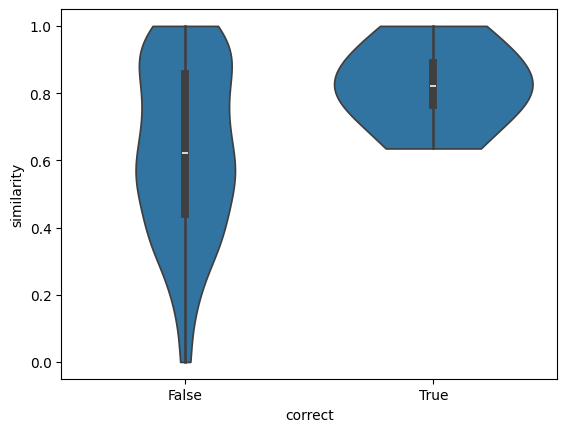

In [81]:
#calculate the correlation between correct and reaction similarity
#print(spearmanr(merged['reaction_similarity'],merged['correct']))
print(ttest_ind(query_df[query_df['correct']]['similarity'], query_df[~query_df['correct']]['similarity']))
sns.violinplot(data=query_df, x='correct', y='similarity', cut=False)

### Visualize some of the reactions with highest and lowest similarity

Something weird is going on here

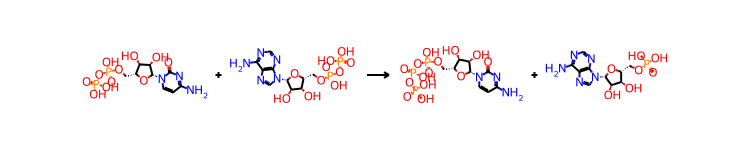

In [82]:
index=0
rxn = query_df['Reaction'].values[index]
EC_number = query_df['0'].values[index]
AllChem.ReactionFromSmarts(rxn, useSmiles=True)

In [87]:
EC_number

'2.7.4.10'

In [88]:
reference_subset = reference_df[reference_df['EC number'] == EC_number]
reference_subset

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC


In [85]:
AllChem.ReactionFromSmarts(reference_subset['Reaction'].values[0], useSmiles=True) 

IndexError: index 0 is out of bounds for axis 0 with size 0